![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# Lab | Making predictions with logistic regression

In this lab, you will be using the [Sakila](https://dev.mysql.com/doc/sakila/en/) database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

### Instructions



1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.


In [201]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

In [202]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [203]:
query = '''
SELECT
    film_id,
	category_id,
	language_id,
	rental_rate,
    Rental_year,
    Rental_month,
     LAG(Rental_month, 1) OVER (PARTITION BY Rental_year ORDER BY film_id) AS last_month
FROM (
    SELECT DISTINCT
        i.film_id,
        f.title AS Title,
        c.category_id,
        l.language_id,
        f.rental_rate,
        DATE_FORMAT(CONVERT(r.rental_date, DATE), '%%m') AS Rental_month,
        DATE_FORMAT(CONVERT(r.rental_date, DATE), '%%Y') AS Rental_year
    FROM sakila.rental r
    JOIN sakila.inventory i ON r.inventory_id = i.inventory_id
    JOIN sakila.film f ON i.film_id = f.film_id
    JOIN sakila.film_category c ON  c.film_id = f.film_id
    JOIN sakila.language l ON l.language_id = f.language_id
    JOIN sakila.film_actor fa ON fa.film_id = f.film_id
    ORDER BY film_id, Rental_year, Rental_month
) subquery;
'''
data = pd.read_sql_query(query, engine)
data.head()

,film_id,category_id,language_id,rental_rate,Rental_year,Rental_month,last_month
0,1,6,1,0.99,2005,05,None
1,1,6,1,0.99,2005,06,05
2,1,6,1,0.99,2005,07,06
3,1,6,1,0.99,2005,08,07
4,2,11,1,4.99,2005,07,08


In [204]:
#Visualizamos que tipo de datos tenemos en el DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   film_id       3660 non-null   int64  
 1   category_id   3660 non-null   int64  
 2   language_id   3660 non-null   int64  
 3   rental_rate   3660 non-null   float64
 4   Rental_year   3660 non-null   object 
 5   Rental_month  3660 non-null   object 
 6   last_month    3657 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 200.3+ KB


2. Read the data into a Pandas dataframe.


3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.


In [205]:
# Establecemos como categoricas las columas que no queremos que sean tratadas como numeros y fijamos como enteros con las cuales queremos realizar operaciones.
data['film_id'] = data['film_id'].astype('object')
data['category_id'] = data['category_id'].astype('object')
data['language_id'] = data['language_id'].astype('object')
data['Rental_month'] = data['Rental_month'].fillna(0).astype(int)
data['last_month'] = data['last_month'].fillna(0).astype(int)


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   film_id       3660 non-null   object 
 1   category_id   3660 non-null   object 
 2   language_id   3660 non-null   object 
 3   rental_rate   3660 non-null   float64
 4   Rental_year   3660 non-null   object 
 5   Rental_month  3660 non-null   int32  
 6   last_month    3660 non-null   int32  
dtypes: float64(1), int32(2), object(4)
memory usage: 171.7+ KB


4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.


In [206]:
# Función que determina si el mes pasado estuvo alquilado o no. Para ello comparmos si el mes anterior es menor a un del mes actual
def last_month(row):
    if (row['last_month'] + 1) == row['Rental_month']:
        return True
    else:
        return False

# Aplicamos la funcion agregando una columna si es verdadero o falsa la condicion
data['True_False'] = data.apply(last_month, axis=1)

In [207]:
data

,film_id,category_id,language_id,rental_rate,Rental_year,Rental_month,last_month,True_False
0,1,6,1,0.99,2005,5,0,False
1,1,6,1,0.99,2005,6,5,True
2,1,6,1,0.99,2005,7,6,True
3,1,6,1,0.99,2005,8,7,True
4,2,11,1,4.99,2005,7,8,False
...,...,...,...,...,...,...,...,...
3655,977,16,1,2.99,2006,2,2,False
3656,982,1,1,0.99,2006,2,2,False
3657,990,11,1,0.99,2006,2,2,False
3658,998,11,1,0.99,2006,2,2,False


In [208]:
#Seleccionamos el mes de julio del 2005 como nuestro mes actual y comparamos si fue alquilada en el mes de junio o no.
new_df = data[data['Rental_month'] == 7]

In [209]:
new_df

,film_id,category_id,language_id,rental_rate,Rental_year,Rental_month,last_month,True_False
2,1,6,1,0.99,2005,7,6,True
4,2,11,1,4.99,2005,7,8,False
8,3,6,1,2.99,2005,7,6,True
10,4,11,1,2.99,2005,7,8,False
15,5,8,1,2.99,2005,7,6,True
...,...,...,...,...,...,...,...,...
3474,996,6,1,0.99,2005,7,6,True
3477,997,12,1,0.99,2005,7,6,True
3481,998,11,1,0.99,2005,7,8,False
3484,999,3,1,2.99,2005,7,8,False


In [210]:
#Eliminamos la columna de mes pasado ya que no aporta para la regresion logistica.
new_df = new_df.drop(columns=['last_month', 'Rental_month', 'Rental_year'], axis=1)

In [211]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955 entries, 2 to 3488
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   film_id      955 non-null    object 
 1   category_id  955 non-null    object 
 2   language_id  955 non-null    object 
 3   rental_rate  955 non-null    float64
 4   True_False   955 non-null    bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 38.2+ KB


5. Create a logistic regression model to predict this variable from the cleaned data.


In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\aguva\AppData\Local\Temp\ipykernel_25760\909921260.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=new_df.corr(method='pearson')  # default


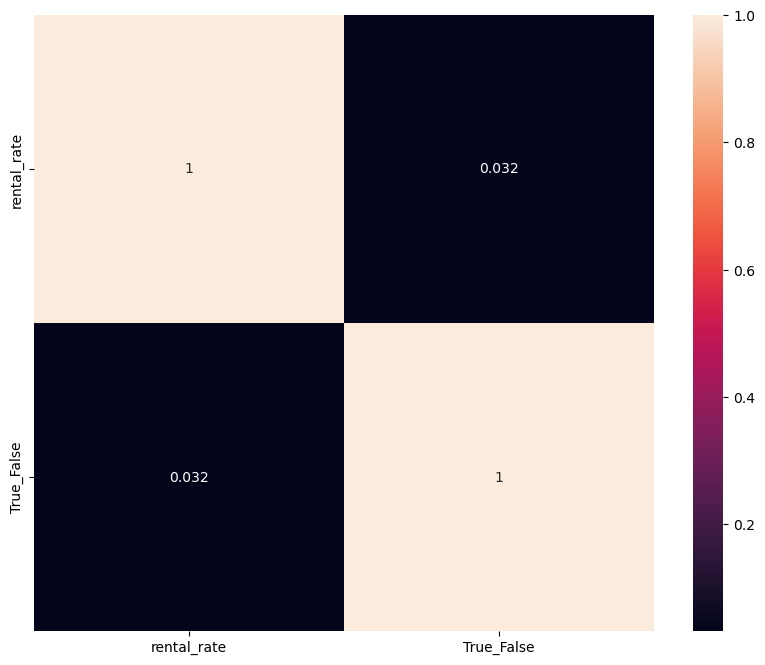

In [213]:
corr_matrix=new_df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

C:\Users\aguva\AppData\Local\Temp\ipykernel_25760\3663831138.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df['rental_rate'])


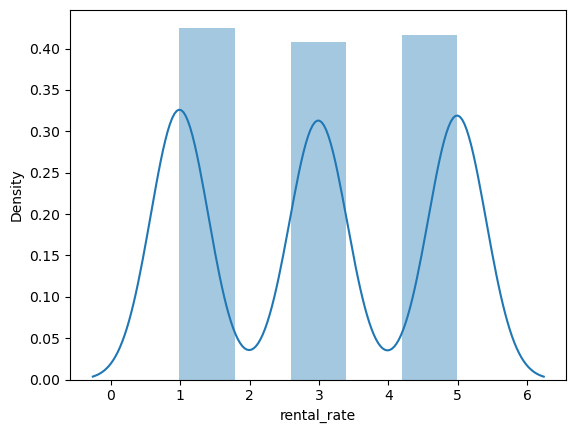

In [214]:
sns.distplot(new_df['rental_rate'])
plt.show()

In [215]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
x = new_df.select_dtypes(include = np.number)


In [216]:
cat = new_df.select_dtypes(include = object)
categorical = pd.get_dummies(cat, columns=['film_id', 'category_id', 'language_id'])

C:\Users\aguva\AppData\Local\Temp\ipykernel_25760\27313670.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorical = pd.get_dummies(cat, columns=['film_id', 'category_id', 'language_id'])
C:\Users\aguva\AppData\Local\Temp\ipykernel_25760\27313670.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorical = pd.get_dummies(cat, columns=['film_id', 'category_id', 'language_id'])
C:\Users\aguva\AppData\Local\Temp\ipykernel_25760\27313670.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorical = pd.get_dummies(cat, columns=['film_id', 'category_id', 'language_id'])


In [217]:
#new_df2 = new_df.drop(columns=['True_False'], axis=1)

In [218]:
categorical

,film_id_1,film_id_2,film_id_3,film_id_4,film_id_5,film_id_6,film_id_7,film_id_8,film_id_9,film_id_10,...,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16,language_id_1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
15,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Train test split

In [219]:
new_df

,film_id,category_id,language_id,rental_rate,True_False
2,1,6,1,0.99,True
4,2,11,1,4.99,False
8,3,6,1,2.99,True
10,4,11,1,2.99,False
15,5,8,1,2.99,True
...,...,...,...,...,...
3474,996,6,1,0.99,True
3477,997,12,1,0.99,True
3481,998,11,1,0.99,False
3484,999,3,1,2.99,False


In [220]:
x.shape

(955, 1)

In [222]:
categorical.shape

(955, 972)

In [224]:
y = new_df['True_False']
X = np.concatenate((x, categorical), axis=1)

In [225]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

### Modelling

In [226]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [227]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.518324607329843

6. Evaluate the results.

Check model accuracy

In [228]:
y_test.value_counts()

False    195
True     187
Name: True_False, dtype: int64

5. Create a logistic regression model to predict this variable from the cleaned data.


In [229]:
pd.Series(predictions).value_counts()

False    213
True     169
dtype: int64

6. Evaluate the results.

In [230]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[112,  83],
       [101,  86]], dtype=int64)

In [231]:
classification.predict_proba(X_test)

array([[0.42654338, 0.57345662],
       [0.37252192, 0.62747808],
       [0.28556923, 0.71443077],
       [0.42654338, 0.57345662],
       [0.51650437, 0.48349563],
       [0.37252192, 0.62747808],
       [0.55120469, 0.44879531],
       [0.59338776, 0.40661224],
       [0.37252192, 0.62747808],
       [0.55655645, 0.44344355],
       [0.67473229, 0.32526771],
       [0.59048529, 0.40951471],
       [0.28556923, 0.71443077],
       [0.60345209, 0.39654791],
       [0.38520459, 0.61479541],
       [0.4879745 , 0.5120255 ],
       [0.59347277, 0.40652723],
       [0.51650437, 0.48349563],
       [0.59347277, 0.40652723],
       [0.51938186, 0.48061814],
       [0.56981489, 0.43018511],
       [0.31617275, 0.68382725],
       [0.28556923, 0.71443077],
       [0.59338776, 0.40661224],
       [0.41341489, 0.58658511],
       [0.51650437, 0.48349563],
       [0.28556923, 0.71443077],
       [0.51491668, 0.48508332],
       [0.60345209, 0.39654791],
       [0.59338776, 0.40661224],
       [0.